In [1]:
# These commands will install the necessary packages and their dependencies in the current env.

# uncomment the following line to install the packages in the current env

#!pip install seaborn scikit-learn==1.6

### Author. Radek Vasicek Ruiz

# Dataset generation

In [2]:
# Modules imports

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import torch

# Random Seed 
np.random.seed(42)


In [3]:

# Fetch and process the Boston Housing dataset from OpenML
def generate_boston_data():
    # Load the Boston housing dataset from OpenML
    boston_dataset = fetch_openml(name="boston", version=1, as_frame=True)

    boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names) #convert data into pandas DataFrame
    boston['MEDV'] = boston_dataset.target

    # Select specific features
    features = ['LSTAT', 'RM']
    x = boston[features].values
    y = boston['MEDV'].values
    return x, y

# Generate random 1D data for specific shapes
def parametric_heart(t):
    x = 16 * np.sin(t)**3
    y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)
    return x, y

def parametric_petal(t):
    r = np.sin(5*t)
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x, y

def parametric_lemniscate(t):
    x = np.cos(t) / (1 + np.sin(t)**2)
    y = np.sin(t) * np.cos(t) / (1 + np.sin(t)**2)
    return x, y

def parametric_circle(t):
    x = np.cos(t)
    y = np.sin(t)
    return x, y

def parametric_spiral_ring(t):
    r = (3 + np.cos(15*(t+np.pi/3.25))) / 4
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x, y

# Function to add noise to data
# Add Gaussian noise to parametric data
def add_noise(data, sigma):
    x, y = data
    x_noisy = x + np.random.normal(0, sigma, len(x))
    y_noisy = y + np.random.normal(0, sigma, len(y))
    return x_noisy, y_noisy

# Function to generate datasets
# Generate multiple synthetic datasets with noise and one real dataset
def generate_datasets(N=500):
    t = np.linspace(-np.pi, np.pi, N)
    x_heart, y_heart = add_noise(parametric_heart(t), 0.2)
    x_star, y_star = add_noise(parametric_petal(t), 0.01)
    x_lemniscate, y_lemniscate = add_noise(parametric_lemniscate(t), 0.01)
    x_circle, y_circle = add_noise(parametric_circle(t), 0.1)
    x_umbrella, y_umbrella = add_noise(parametric_spiral_ring(t), 0.0001)
    x_boston, y_boston = generate_boston_data()

    # Generate random 1D data for specific shapes
    # Adjust positions and scales of generated datasets
    X1, Y1 = x_heart, y_heart + 3
    X2, Y2 = 5*x_star, 5*y_star
    X3, Y3 = 4*x_lemniscate, 4*y_lemniscate - 16
    X4, Y4 = 7*x_circle, 7*y_circle
    X5, Y5 = 4.5*x_umbrella, 4.5*y_umbrella
    
    # Generate complex sinusoidal pattern with noise
    X6_ = np.linspace(0, 2*np.pi, N)
    Y6_ = 1.0 * np.sin(1.0 * X6_) + 2.0 * np.cos(0.5 * X6_) + np.random.normal(0, 0.2, size=X6_.shape)
    X6 = np.concatenate([X6_ , -X6_ + 6 ])[::2]
    Y6  = np.concatenate([Y6_, Y6_])[::2]
    X7, Y7 = x_boston, y_boston 

    # Package datasets into a list with identifiers
    data_arr = [(np.stack([X1, Y1],axis=1),1),\
                (np.stack([X2, Y2],axis=1),2),\
                (np.stack([X3, Y3],axis=1),3),\
                (np.stack([X4, Y4],axis=1),4),\
                (np.stack([X5 - 10, Y5 + 8],axis=1),5),\
                (np.stack([X6 + 8, Y6 + 8],axis=1),6),\
                (X7, Y7)]
    
    return data_arr

In [4]:
# Function to get random data
# Returns either synthetic or Boston housing data for experiments.
# Synthetic: combines 6 random parametric datasets; Boston: real regression data.

def get_data(num_feats=1, BOSTON=False):
    if BOSTON:
        # Use Boston housing dataset (last entry in generated datasets)
        data_arr = generate_datasets(N=1000)
        x,y = data_arr[-1]
        if num_feats <= 1:
            return x[:, :1], y   # Return only the first feature if requested
        return x, y              # Return all features

    # Use synthetic data: stack random parametric shapes and assign labels
    data_arr = generate_datasets(N=1000)
    ids = np.random.choice(np.arange(0, len(data_arr)-1), size=6, replace=False) 
    xy_arr = []
    z_arr = []
    for idx in ids:
        xy,z = data_arr[idx]
        #print(ids, idx, x.shape, x.ndim, y.shape)
        xy_arr.append(xy)
        z_arr.append(z*np.ones(xy.shape[0]).astype(int))
    #print(len(x_arr))
    xy_arr = np.concatenate(xy_arr,axis=0)
    z_arr = np.concatenate(z_arr,axis=0)
    return xy_arr, z_arr

In [5]:
from sklearn.model_selection import train_test_split

# Splits input data into train and test sets, then converts them to PyTorch tensors.

def generate_test_train_data(X,Y):
    # Split dataset into train and test partitions (80/20 split)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
    d = X_train.shape[1]
    
    # Convert train/test data to PyTorch tensors with appropriate shapes
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, d)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, d)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

    # prints 
    print('Input train dimensions:', X_train.shape, '->', X_train_tensor.shape)
    print('Output train dimensions:', Y_train.shape, '->', Y_train_tensor.shape)
    print('Input test dimensions:', X_test.shape, '->', X_test_tensor.shape)
    print('Output test dimensions:', Y_test.shape, '->', Y_test_tensor.shape)

    # Store splits in numpy arrays and PyTorch tensors dictionaries
    np_data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test
    }
    torch_data = {
        'X_train': X_train_tensor,
        'Y_train': Y_train_tensor,
        'X_test': X_test_tensor,
        'Y_test': Y_test_tensor
    }
    return np_data, torch_data


Input train dimensions: (404, 1) -> torch.Size([404, 1])
Output train dimensions: (404,) -> torch.Size([404, 1])
Input test dimensions: (102, 1) -> torch.Size([102, 1])
Output test dimensions: (102,) -> torch.Size([102, 1])


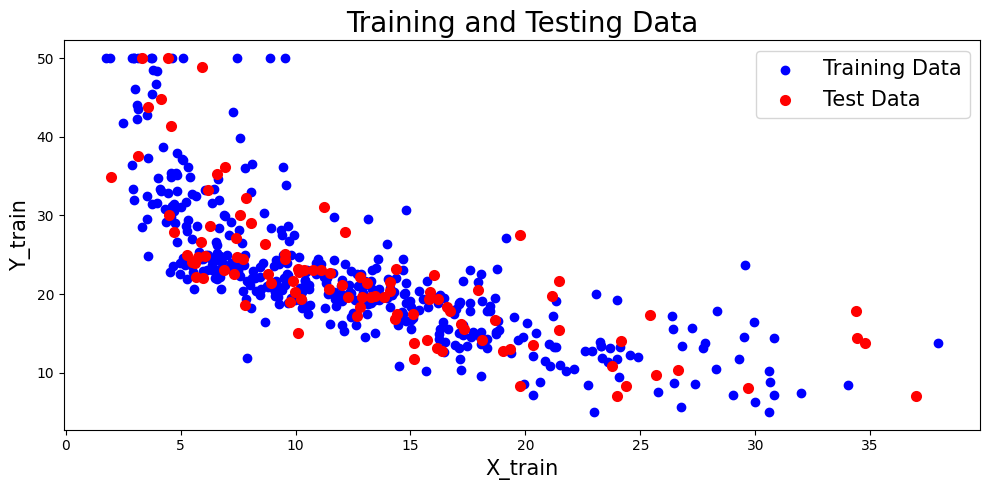

In [6]:
X,Y = get_data(1,True)
np_data, torch_data = generate_test_train_data(X,Y)
# Convert numpy arrays to torch tensors
X_train = np_data['X_train']
Y_train = np_data['Y_train']
X_test = np_data['X_test']
Y_test = np_data['Y_test']

X_train_tensor = torch_data['X_train']
Y_train_tensor = torch_data['Y_train']
X_test_tensor = torch_data['X_test']
Y_test_tensor = torch_data['Y_test']

# Plot training data
plt.figure(figsize=(10, 5))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.scatter(X_test, Y_test, color='red', linewidth=2, label='Test Data')
plt.xlabel('X_train',fontsize=15)
plt.ylabel('Y_train',fontsize=15)
plt.title('Training and Testing Data',fontsize=20)
plt.legend(fontsize=15)

plt.tight_layout()
plt.show()

# Linear Regression

* Linear regression is a supervised machine learning algorithm

* Its predicted output is continuous

* There are two main types:

    * Simple regression $\begin{align} p = w x + b \notag\end{align}$
    * Multivariable regression $\begin{align} f(x,y,z) = w_1 x + w_2 y + w_3 z + b\notag\end{align}$

where,<br> 
        -  <b>$p$</b> and <b>$f(x,y,z)$</b> are the predictions (dependent variable) <br>
        -  <b>$w$</b> represents the weight <br>
        -  <b>$b$</b> is the bias term <br>
        -  <b>$x, y$</b> and <b>$z$</b> are the inputs (independent variable(s))
    
The model will try to learn the optimum values for weight and bias terms to get the line of best fit.

## Loss Function

* A loss function is required to optimize the weights

* Root Mean Squared Error (RMSE) is used a typical loss function used

* Goal is to improve the accuracy of model by minimizing the RMSE 

* RMSE can be calculated as:

\begin{align} RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - (wx_i + b))^2} \notag\end{align}

where,<br> 
    - <b><i>$N$</i></b> is the total number of observations <br>
    - <b>$\frac{1}{N} \sum_{i=1}^{N}$</b> is the averaging operation <br>
    - <b>$y_i$</b> is the actual or ground-truth value <br>
    - <b>$(wx_i + b)$</b> is the prediction

## Gradient Descent

* Gradient descent is used to update the weights

* Need to calculate the gradient of loss function w.r.t $w$ and $b$

* loss function:

\begin{align} f(w,b) =  \frac{1}{N} \sum_{i=1}^{N} (y_i - (wx_i + b))^2 \notag\end{align}

* Gradient can be calculated as:

\begin{align}
f'(w,b) =
   \begin{bmatrix}
     \frac{df}{dw}\\
     \frac{df}{db}\\
    \end{bmatrix}
=
   \begin{bmatrix}
     \frac{1}{N} \sum -2x_i(y_i - (wx_i + b)) \\
     \frac{1}{N} \sum -2(y_i - (wx_i + b)) \\
    \end{bmatrix} \notag
\end{align}

In [7]:

# SimpleLinearRegression implements manual linear regression with SGD using PyTorch tensors.

class SimpleLinearRegression:
    def __init__(self, learning_rate=0.0001, epochs=1000, batch_size=10):
        # Initialize hyperparameters and weights
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.w = None
        self.b = None

 
    def simple_LinR(self, x):
        # Forward pass: Linear regression model
        return torch.matmul(x, self.w) + self.b

    def loss_function(self, x, y):
        # Compute the Mean Squared Error (MSE) loss
        preds = self.simple_LinR(x)
        loss = torch.mean((y - preds) ** 2)
        return loss


    def update_weights(self, x, y):      
        # Manual gradient descent step for weights and bias
        N = x.size(0)
        preds = self.simple_LinR(x)
        grad_w = (2/N) * torch.matmul(x.t(), (preds - y))
        grad_b = (2/N) * torch.sum(preds - y)
        self.w -= self.learning_rate * grad_w
        self.b -= self.learning_rate * grad_b
        return self.w, self.b


    def fit(self, x, y):
        # Initialize weights and bias randomly
        self.w = torch.randn((x.size(1), 1), requires_grad=False, dtype=torch.float32)
        self.b = torch.randn(1, requires_grad=False, dtype=torch.float32)
        train_loss = []
        n_samples = x.size(0)
        for epoch in range(self.epochs):
            # Shuffle data each epoch
            perm = torch.randperm(n_samples)
            x_shuffled = x[perm]
            y_shuffled = y[perm]
            epoch_loss = 0.0
            n_batches = int(np.ceil(n_samples / self.batch_size))
            for i in range(n_batches):
                start = i * self.batch_size
                end = min(start + self.batch_size, n_samples)
                xb = x_shuffled[start:end]
                yb = y_shuffled[start:end]
                # Compute loss and update weights for this batch
                loss = self.loss_function(xb, yb)
                self.update_weights(xb, yb)
                epoch_loss += loss.item() * (end - start)
            epoch_loss /= n_samples
            train_loss.append(epoch_loss)
            # Print loss every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')
        print("Training complete.")
        print(f'Final weights: {self.w.squeeze().tolist()}')
        print(f'Final bias: {self.b.item()}')
        return self.w, self.b, train_loss
        

    def predict(self, x):
        return self.simple_LinR(x)

## Run scikit model

Training completed
[-0.97981166] 34.87291567862843


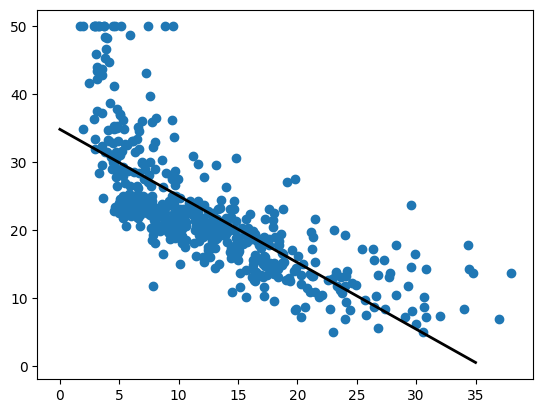

In [8]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()  # A simple linear regression model

lin_model.fit(X_train, Y_train)  # Train our model
print("Training completed")
print(lin_model.coef_ , lin_model.intercept_)

x_plot = np.linspace(0, 35, 1000)
y_plot = lin_model.predict(x_plot[:, np.newaxis])
plt.scatter(X, Y)
plt.plot(x_plot, y_plot, color="black", linewidth=2)
plt.show()

## Run custom model fit

Epoch [100/1000], Loss: 72.3236
Epoch [200/1000], Loss: 28.9829
Epoch [300/1000], Loss: 61.8357
Epoch [400/1000], Loss: 44.0240
Epoch [500/1000], Loss: 64.5430
Epoch [600/1000], Loss: 46.7139
Epoch [700/1000], Loss: 31.8779
Epoch [800/1000], Loss: 84.7288
Epoch [900/1000], Loss: 43.8719
Epoch [1000/1000], Loss: 25.8525
Training complete.
Final weights: -0.9186833500862122
Final bias: 34.79413986206055
Predictions shape: torch.Size([102, 1])


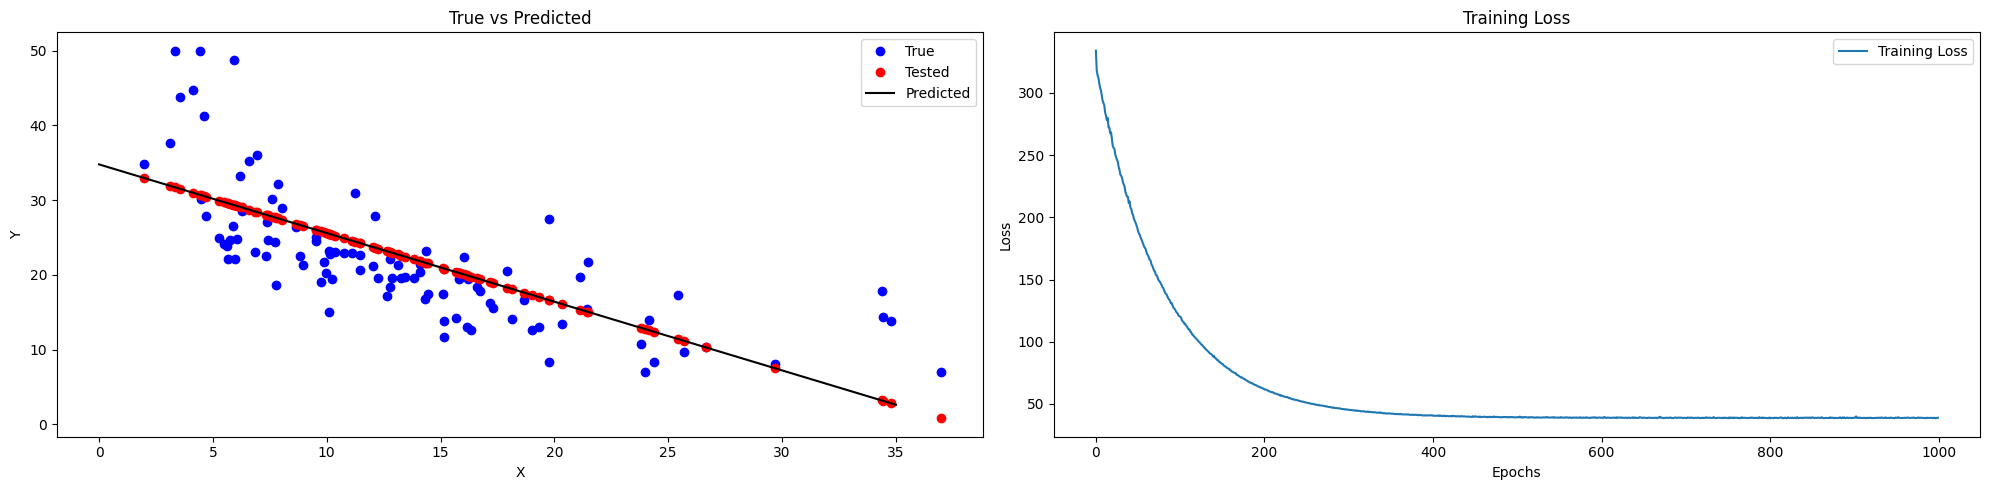

In [9]:
# Task4: Fit the model you implemented above to the Boston dataset
# Assume X_train_tensor and Y_train_tensor are already defined above

# Initialize the model with default hyperparameters
model = SimpleLinearRegression(learning_rate=0.001, epochs=1000, batch_size=32)

# Train the model and get training loss history
w, b, train_loss = model.fit(X_train_tensor, Y_train_tensor)

# Make predictions
Y_pred = model.predict(X_test_tensor)
y_plot_m = model.predict(torch.tensor(x_plot).view(-1,1).float())
print("Predictions shape:", Y_pred.shape)

# Plot the results
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(X_test_tensor, Y_test_tensor, 'bo', label='True')
plt.plot(X_test_tensor, Y_pred, 'ro', label='Tested')
plt.plot(x_plot, y_plot_m, 'k', label='Predicted')
plt.title('True vs Predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.subplot(122)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

## Compare performace with SK model

In [10]:
print("Any NaNs in X_train_tensor?", torch.isnan(X_train_tensor).any())
print("Any NaNs in Y_train_tensor?", torch.isnan(Y_train_tensor).any())
print("Any Infs in X_train_tensor?", torch.isinf(X_train_tensor).any())
print("Any Infs in Y_train_tensor?", torch.isinf(Y_train_tensor).any())

Any NaNs in X_train_tensor? tensor(False)
Any NaNs in Y_train_tensor? tensor(False)
Any Infs in X_train_tensor? tensor(False)
Any Infs in Y_train_tensor? tensor(False)


In [11]:
print("X_train_tensor min/max:", X_train_tensor.min().item(), X_train_tensor.max().item())
print("Y_train_tensor min/max:", Y_train_tensor.min().item(), Y_train_tensor.max().item())

X_train_tensor min/max: 1.7300000190734863 37.970001220703125
Y_train_tensor min/max: 5.0 50.0


In [12]:
print("NaNs in prediction:", np.isnan(Y_pred).any())

NaNs in prediction: tensor(0, dtype=torch.uint8)


In [13]:
from sklearn.metrics import mean_squared_error
# Evaluate model performance for the training set

# Get predictions from the sklearn linear regression model (returns a NumPy array)
y_train_predict_sk = lin_model.predict(X_train)

# Get predictions from our PyTorch model (returns a tensor)
y_train_predict = model.predict(X_train_tensor)

# Try to convert PyTorch output to NumPy array and flatten it for sklearn
try:
    if hasattr(y_train_predict, 'detach'):
        y_train_predict = y_train_predict.detach().cpu().numpy()
    y_train_predict = y_train_predict.flatten()
except Exception as e:
    print("Error converting PyTorch predictions to NumPy:", e)

# Calculate RMSE (Root Mean Squared Error) for both models
rmse_sk = (np.sqrt(mean_squared_error(Y_train, y_train_predict_sk)))
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
print("The model performance for training set")
print("--------------------------------------")
print('RMSE of SK model is {}'.format(rmse_sk))
print('RMSE of pytorch model is {}'.format(rmse))
print("\n")

# model evaluation for testing set
y_test_predict_sk = lin_model.predict(X_test)
y_test_predict = model.predict(X_test_tensor)
rmse_sk = (np.sqrt(mean_squared_error(Y_test, y_test_predict_sk)))
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# print(Y_test)
# print(y_test_predict)
print("The model performance for testing set")
print("--------------------------------------")
print('RMSE of SK model is {}'.format(rmse_sk))
print('RMSE of pytorch model is {}'.format(rmse))

The model performance for training set
--------------------------------------
RMSE of SK model is 6.201452973865344
RMSE of pytorch model is 6.2538402216416955


The model performance for testing set
--------------------------------------
RMSE of SK model is 6.230716573098682
RMSE of pytorch model is 6.185450891667182


## Multivariable Regression

\begin{align} f(x,y,z) = w_1 x + w_2 y + w_3 z \notag\end{align}

### Loss Function

\begin{align} MSE =  \frac{1}{N} \sum_{i=1}^{N} (f_i - (w_1x_i + w_2y_i + w_3z_i))^2 \notag\end{align}

### Gradients

\begin{align*}
\partial_{b}f = \frac{1}{N} \sum_{i=1}^{N} -2(f_i - (w_1x_i + w_2y_i + w_3z_i - b)) \\
\partial_{w_1}f = \frac{1}{N} \sum_{i=1}^{N} -2x_i(f_i - (w_1x_i + w_2y_i + w_3z_i - b)) \\
\partial_{w_2}f = \frac{1}{N} \sum_{i=1}^{N} -2y_i(f_i - (w_1x_i + w_2y_i + w_3z_i - b)) \\
\partial_{w_2}f = \frac{1}{N} \sum_{i=1}^{N} -2z_i(f_i - (w_1x_i + w_2y_i + w_3z_i  - b)) 
\end{align*}

### Execution
* We already created a model for predicting the housing prices in Boston using only `LSTAT` feature
* Lets add the second most correlated feature `RM` and compare the results

Input train dimensions: (404, 2) -> torch.Size([404, 2])
Output train dimensions: (404,) -> torch.Size([404, 1])
Input test dimensions: (102, 2) -> torch.Size([102, 2])
Output test dimensions: (102,) -> torch.Size([102, 1])


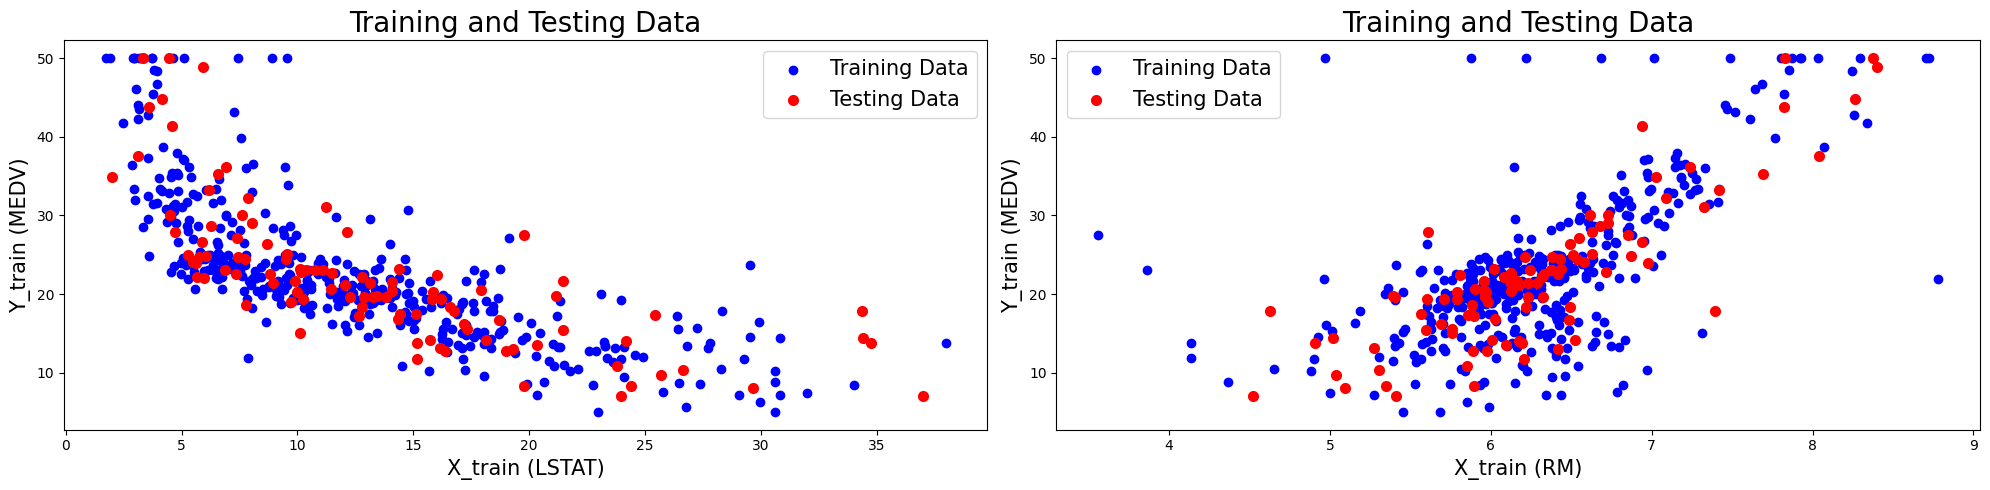

In [14]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
X,Y = get_data(2,True)
np_data, torch_data = generate_test_train_data(X,Y)
# Convert numpy arrays to torch tensors
X_train = np_data['X_train']
Y_train = np_data['Y_train']
X_test = np_data['X_test']
Y_test = np_data['Y_test']

X_train_tensor = torch_data['X_train']
Y_train_tensor = torch_data['Y_train']
X_test_tensor = torch_data['X_test']
Y_test_tensor = torch_data['Y_test']

# Plot training data
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    plt.scatter(X_train[:,i], Y_train, color='blue', label='Training Data')
    plt.scatter(X_test[:,i], Y_test, color='red', linewidth=2, label='Testing Data')
    plt.xlabel(f'X_train ({col})',fontsize=15)
    plt.ylabel(f'Y_train (MEDV)',fontsize=15)
    plt.title('Training and Testing Data',fontsize=20)
    plt.legend(fontsize=15)
    plt.tight_layout()

Training completed
[-0.71722954  4.58938833] 2.73624034260661
(1000, 2) (404, 2)


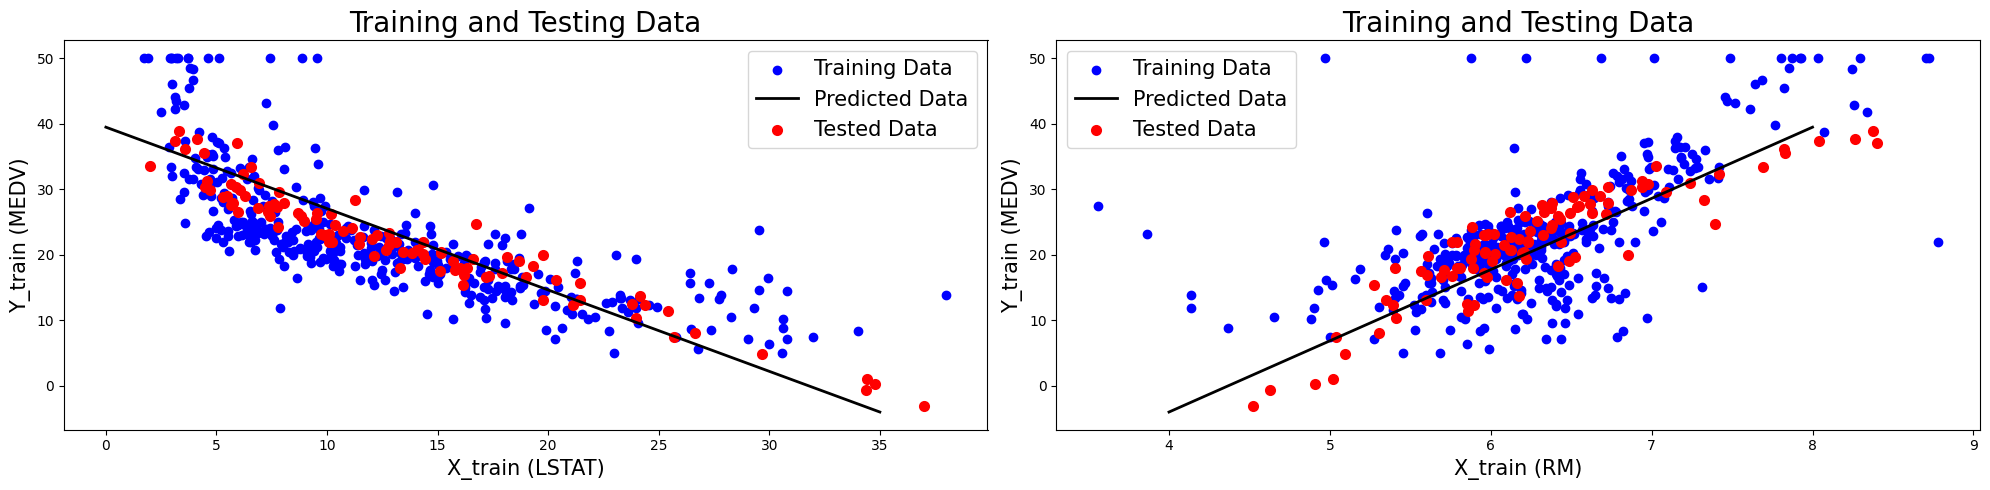

In [15]:
#use scikit to train the model
lin_model2 = LinearRegression()  #using scikit LinearRegression
lin_model2.fit(X_train, Y_train) #train our model
print("Training completed")
print(lin_model2.coef_ , lin_model2.intercept_)

x_plot1 = np.linspace(0, 35, 1000)
x_plot2 = np.linspace(4, 8, 1000)[::-1]
x_plot = np.stack((x_plot1, x_plot2), axis=1)
print(x_plot.shape, X_train.shape)
y_plot = lin_model2.predict(x_plot)
y_test = lin_model2.predict(X_test)


# Plot data
plt.figure(figsize=(20, 5))
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    #x_plot = x_plot1 if i == 0 else x_plot2
    #y_plot = y_plot1 if i == 0 else y_plot2
    plt.scatter(X_train[:,i], Y_train, color='blue', label='Training Data')
    plt.plot(x_plot[:,i], y_plot, color='k', linewidth=2, label='Predicted Data')
    plt.scatter(X_test[:,i], y_test, color='red', linewidth=2, label='Tested Data')
    plt.xlabel(f'X_train ({col})',fontsize=15)
    plt.ylabel(f'Y_train (MEDV)',fontsize=15)
    plt.title('Training and Testing Data',fontsize=20)
    plt.legend(fontsize=15)
    plt.tight_layout()



torch.Size([404, 2]) torch.Size([404, 1])
torch.Size([102, 2]) torch.Size([102, 1])
Epoch [100/1000], Loss: 34.9627
Epoch [200/1000], Loss: 31.9074
Epoch [300/1000], Loss: 34.0536
Epoch [400/1000], Loss: 19.3215
Epoch [500/1000], Loss: 39.4612
Epoch [600/1000], Loss: 24.6148
Epoch [700/1000], Loss: 10.4609
Epoch [800/1000], Loss: 25.4796
Epoch [900/1000], Loss: 22.6933
Epoch [1000/1000], Loss: 39.2493
Training complete.
Final weights: [-0.7594537734985352, 4.874948024749756]
Final bias: 0.4334230124950409


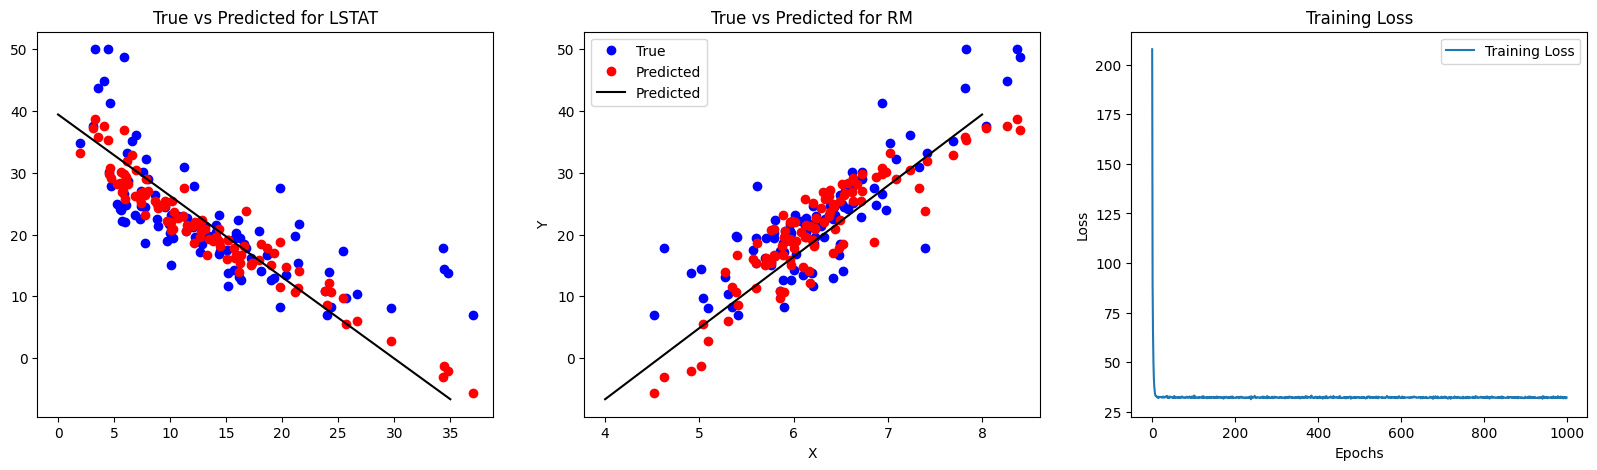

In [16]:
# Task5: Fit the model you implemented above to the Boston dataset
# Initialize the linear regression model (using both features: LSTAT and RM)

#### learning_rate < 0.01 else blows up producing nan error
model2 = SimpleLinearRegression(learning_rate=0.001, epochs=1000, batch_size=32)

# Print shapes to verify data compatibility
print(X_train_tensor.shape, Y_train_tensor.shape)
print(X_test_tensor.shape, Y_test_tensor.shape)

# Train the model and record the training loss
w, b, train_loss = model2.fit(X_train_tensor, Y_train_tensor)

# Use the trained model to predict outputs for the test set and for plotting
Y_pred = model2.predict(X_test_tensor)
y_plot_m = model2.predict(torch.tensor(x_plot).float())

# Plot the results
plt.figure(figsize=(20, 5))
plt.subplot(131);plt.plot(X_test_tensor[:,0], Y_test_tensor, 'bo', label='True');plt.plot(X_test_tensor[:,0], Y_pred, 'ro', label='Tested')
plt.plot(x_plot[:,0], y_plot_m, 'k', label='Predicted')
plt.title('True vs Predicted for LSTAT')
plt.subplot(132);plt.plot(X_test_tensor[:,1], Y_test_tensor, 'bo', label='True');plt.plot(X_test_tensor[:,1], Y_pred, 'ro', label='Predicted');
plt.plot(x_plot[:,1], y_plot_m, 'k', label='Predicted')
plt.title('True vs Predicted for RM')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.subplot(133)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Compare performace with SK model

In [17]:
# model evaluation for training set
y_train_predict_sk = lin_model2.predict(X_train)
y_train_predict = model2.predict(X_train_tensor)
rmse_sk = (np.sqrt(mean_squared_error(Y_train, y_train_predict_sk)))
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
print("The model performance for training set")
print("--------------------------------------")
print('RMSE of SK model is {}'.format(rmse_sk))
print('RMSE of pytorch model is {}'.format(rmse))
print("\n")

# model evaluation for testing set
y_test_predict_sk = lin_model2.predict(X_test)
y_test_predict = model2.predict(X_test_tensor)
rmse_sk = (np.sqrt(mean_squared_error(Y_test, y_test_predict_sk)))
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
# print(Y_test)
# print(y_test_predict)
print("The model performance for testing set")
print("--------------------------------------")
print('RMSE of SK model is {}'.format(rmse_sk))
print('RMSE of pytorch model is {}'.format(rmse))

The model performance for training set
--------------------------------------
RMSE of SK model is 5.637129335071195
RMSE of pytorch model is 5.74818759301691


The model performance for testing set
--------------------------------------
RMSE of SK model is 5.137400784702911
RMSE of pytorch model is 5.383832503950587


### Some observations


* By adding one more feature the resulting RMSE is smaller
* That means our model improved when compared with the other one

# Multi-Label Classification

data shape: (6000, 2) (6000,)


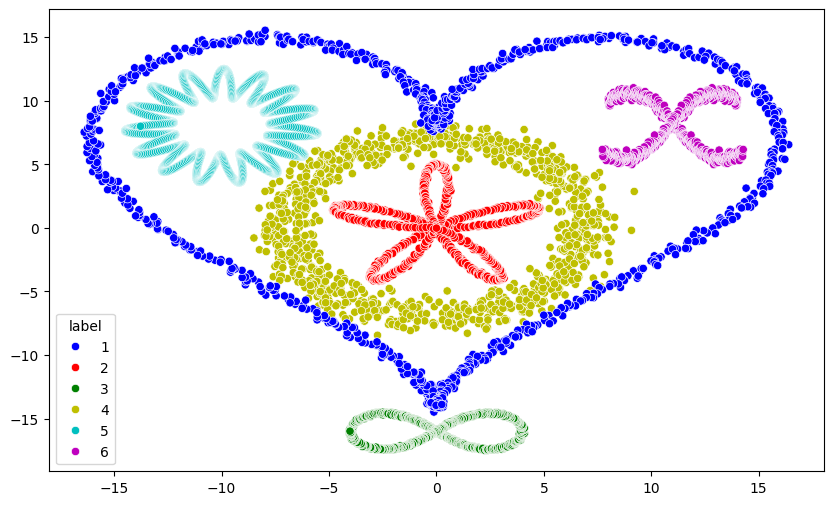

In [18]:
XY,Z = get_data(6)
#Z = (Z_[None,:]*np.ones_like(XY.reshape((-1,6,2))[:,:,0])).flatten().astype(int)
print("data shape:", XY.shape,Z.shape)
cols = ['b', 'r', 'g', 'y', 'c', 'm']
X, Y = XY[:,0], XY[:,1]
df = pd.DataFrame({'X': X, 'Y': Y, 'label': Z},columns=['X', 'Y', 'label'])
#print(df.head())
plt.figure(figsize=(10, 6))
#plt.plot(X,Y,'.',color=cols[Z[0]-1], label=f'Data{Z[0]}')
sns.scatterplot(x=X,y=Y,hue='label', data=df, palette=cols, legend="full")
XY = XY.reshape((6,1000,2)).swapaxes(0,1)
Z = Z.reshape((6,1000)).T

In [19]:
import torch
import numpy as np

# Number of samples
def generate_sample(XY,Z, sample_size=1000, input_size = 256):
    sampled_input = np.zeros((sample_size, input_size, 2))
    sampled_label = np.zeros((sample_size, input_size))
    for k,s in enumerate(range(sample_size)):
        i = np.random.randint(0,6)
        #print(i)
        # Randomly sample num_samples from the data in the i-th category
        indices = np.random.choice(XY.shape[0], input_size, replace=False)
        sampled_input[k] = XY[indices,i,:]
        sampled_label[k] = Z[indices,i]

    # Convert the numpy array to a PyTorch tensor
    sampled_input_tensor = torch.tensor(sampled_input, dtype=torch.float32)
    sampled_label_tensor = torch.tensor(sampled_label, dtype=torch.int)

    # Print the shape of the resulting tensor
    # The shape should be 50x2, 50
    print("Shape of sampled data tensor:", sampled_input_tensor.shape, sampled_label_tensor.shape)
    return sampled_input_tensor, sampled_label_tensor

X_train, Y_train = generate_sample(XY,Z,5000,50)
X_test, Y_test = generate_sample(XY,Z,100,50)


Shape of sampled data tensor: torch.Size([5000, 50, 2]) torch.Size([5000, 50])
Shape of sampled data tensor: torch.Size([100, 50, 2]) torch.Size([100, 50])


Batch index: 0
Data shape: torch.Size([100, 50, 2])
Target shape: torch.Size([100, 50])
Target prob shape: torch.Size([100, 6])


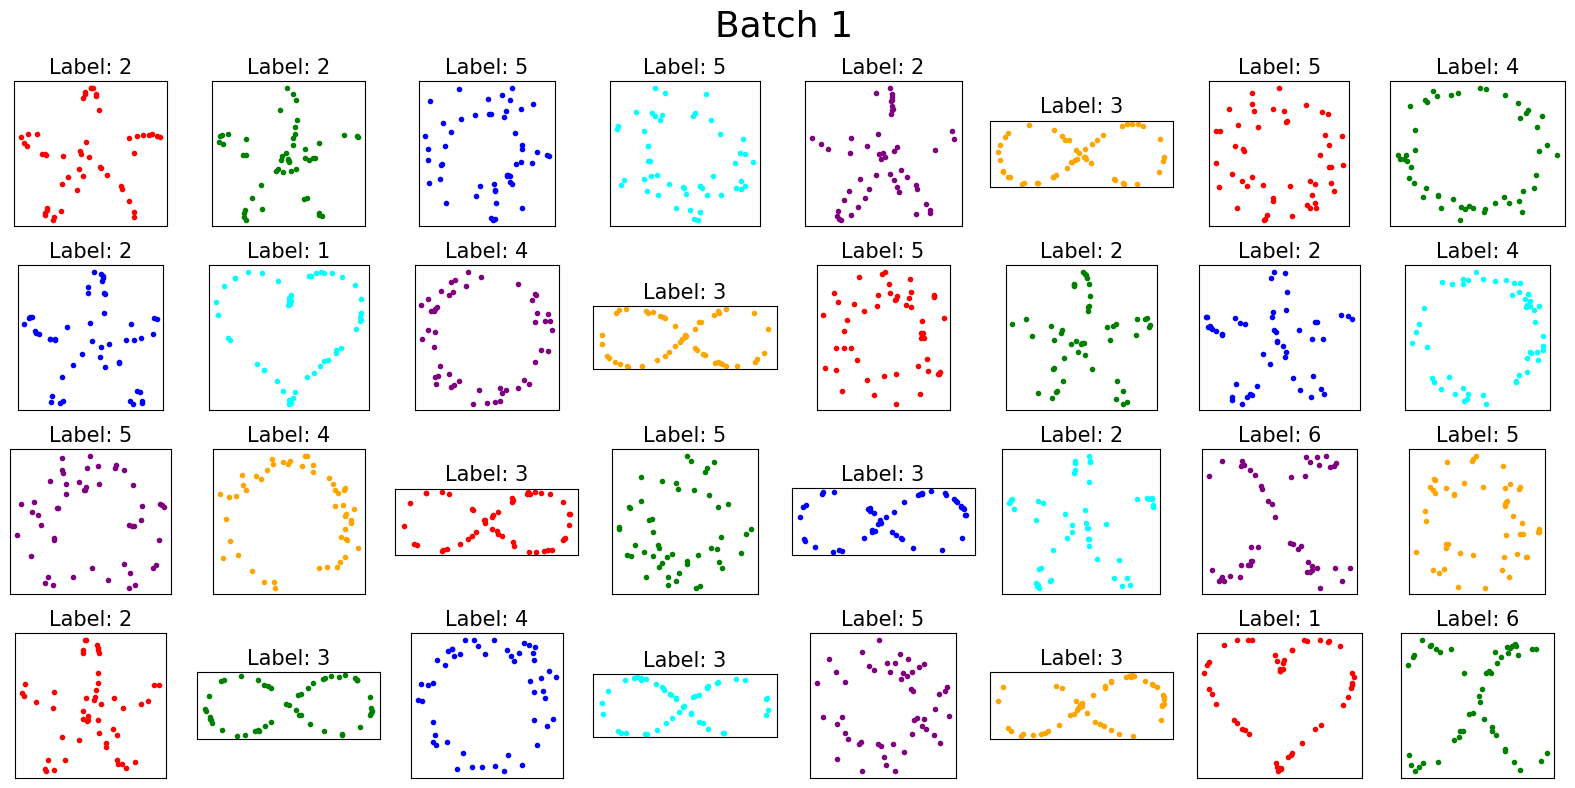

In [20]:
# Pattern dataset class
class PatternDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.data_len, self.input_size, self.feat_size = X.shape

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        sample_X = self.X[idx]
        sample_Y = self.Y[idx]
        sample_P = torch.zeros(6)
        pid = self.Y[idx].float().mean()
        sample_P[int(pid)-1] = 1
        return sample_X, sample_Y, sample_P
    

# Create an instance of the custom dataset
pattern_train_dataset = PatternDataset(X_train, Y_train)
pattern_test_dataset = PatternDataset(X_test, Y_test)

# Example of how to use the custom dataset with a DataLoader
train_dataloader = torch.utils.data.DataLoader(pattern_train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(pattern_test_dataset, batch_size=132, shuffle=False)
# Iterate through the dataloader to access the data
for batch_idx, (data, target, probs) in enumerate(test_dataloader):
    print("Batch index:", batch_idx)
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)
    print("Target prob shape:", probs.shape)
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    colors = ['red', 'green', 'blue', 'cyan', 'purple', 'orange']
    for i in range(4):
        for j in range(8):
            k = (i * 8 + j)
            color_index = k % len(colors)
            axes[i, j].plot(data[k][:, 0], data[k][:, 1], '.', color=colors[color_index])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_aspect('equal', adjustable='box')
            axes[i, j].grid(True)
            axes[i, j].set_title(f"Label: {target[k][0].item()}", fontsize=15)
    plt.suptitle(f"Batch {batch_idx + 1}", fontsize=26)
    plt.tight_layout()
    plt.show()
    break

In [21]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from IPython import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, f1_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


FEAT_SIZE = 2
INP_SIZE = 50
HIDDEN_SIZE = 64
OUT_SIZE = 6

# Define the model
# Task6: Implement a Multi-Layer Perceptron (MLP) model using PyTorch nn module
# https://docs.pytorch.org/docs/2.2/nn.html
# Define a simple Multi-Layer Perceptron for multi-class classification
class MLPModel(nn.Module):
    def __init__(self, input_dim=INP_SIZE * FEAT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUT_SIZE):
        super(MLPModel, self).__init__()
        # Task6.1: Define layers
        # First linear layer maps input to hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Activation function (ReLU for non-linearity)
        self.relu = nn.ReLU()
        # Second linear layer maps hidden layer to output
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # (Optional: add more layers for a deeper MLP)

    def forward(self, x):
        # Task6.2: Implement the forward pass of the MLP model
        # x: input tensor of shape (batch_size, input_dim)
        # Pass input through first linear layer
        out = self.fc1(x)
        # Apply activation
        out = self.relu(out)
        # Pass through second linear (output) layer
        out = self.fc2(out)
        # Return final output (logits, not probabilities)
        # return: output tensor of shape (batch_size, output_dim)
        return out

# Evaluate the model
def evaluate_model(model,test_dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target, probs in reversed(list(test_dataloader)):
            idata = data.view(-1, INP_SIZE * FEAT_SIZE)
            target = target.float().mean(dim=1).long()
            outputs = model(idata)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy()+1)
            all_targets.extend(target.cpu().numpy())

    display.clear_output(wait=True)

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and thresholds
    # Binarize the targets and predictions for multi-label classification
    binarized_targets = np.zeros((len(all_targets), OUT_SIZE))
    binarized_preds = np.zeros((len(all_preds), OUT_SIZE))

    for i, label in enumerate(range(1, OUT_SIZE + 1)):
        binarized_targets[:, i] = (np.array(all_targets) == label).astype(int)
        binarized_preds[:, i] = (np.array(all_preds) == label).astype(int)

    # Calculate precision, recall, and thresholds for each label
    precision = {}
    recall = {}
    thresholds = {}
    f1_scores = {}

    for i, label in enumerate(range(1, OUT_SIZE + 1)):
        precision[label], recall[label], thresholds[label] = precision_recall_curve(
        binarized_targets[:, i], binarized_preds[:, i]
        )
        f1_scores[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
        f1_scores[label] = f1_scores[label][:-1]  # Remove the last element to match the length of thresholds

    plt.figure(figsize=(8, 6))
    
    # Plot Precision-Recall curve for each class
    plt.subplot(221)
    for label in range(1, OUT_SIZE + 1):
        plt.plot(recall[label], precision[label], label=f'Class {label}')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Class-specific PR Curves', fontsize=16)
    plt.grid(True)
    plt.legend()

    # Plot F1 score curve for each class
    plt.subplot(222)
    for label in range(1, OUT_SIZE + 1):
        plt.plot(thresholds[label], f1_scores[label], label=f'Class {label}')
    plt.xlabel('Thresholds', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.title('Class-specific F1 Score', fontsize=16)
    plt.grid(True)
    plt.legend()
    
    # Plot Confusion Matrix
    plt.subplot(223)
    cm = confusion_matrix(all_targets, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=range(1, OUT_SIZE + 1))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format=".1f", ax=plt.gca())
    plt.title('Confusion Matrix (%)', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    
    
    plt.subplot(224)
    for k in range(6):
        tc_ids = k % len(colors)
        cids = target == k+1
        if cids.sum() == 0:
            continue
        pids = predicted[cids]
        pc_ids = pids % len(colors)
        #print(data[cids].shape, pc_ids)
        fids = ~(pids == k)
        plt.plot(data[cids,:, 0].cpu().numpy(), data[cids, :, 1].cpu().numpy(), '.', mfc='none', color=colors[tc_ids])
        #plt.plot(data[cids,:, 0].cpu().numpy(), data[cids, :, 1].cpu().numpy(), 'x', color=colors[tc_ids])
        plt.plot(data[cids,:, 0][fids].cpu().numpy(), data[cids, :, 1][fids].cpu().numpy(), 'kx')
    
    plt.plot(data[0,:, 0].cpu().numpy(), data[0, :, 1].cpu().numpy(), 'kx', label=f'missed')
    plt.title('Predicted Labels', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.legend(loc='lower left', fontsize=12)  
    
    plt.tight_layout()
    plt.show()


Epoch [5/100], Loss: 0.0251
Epoch [10/100], Loss: 0.0003
Epoch [15/100], Loss: 0.0315
Epoch [20/100], Loss: 0.0023
Epoch [25/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0006
Epoch [35/100], Loss: 0.0018
Epoch [40/100], Loss: 0.0000
Epoch [45/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0004
Epoch [55/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0003
Epoch [65/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0001
Epoch [75/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [85/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [95/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


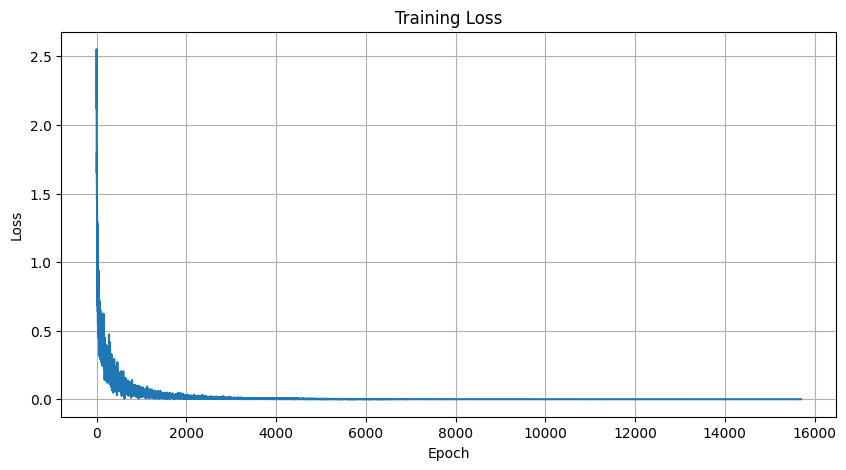

In [24]:
model = MLPModel()

# Define loss function and optimizer
# Task7: Define loss function and optimizer. Use torch inbuilt functions. 
# https://docs.pytorch.org/docs/2.2/nn.html#loss-functions
# https://docs.pytorch.org/docs/2.2/optim.html#module-torch.optim
# Use CrossEntropyLoss for multi-class classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Use Adam optimizer to update model weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
loss_values = []

# Create a list to store loss values
loss_values = []
for epoch in range(num_epochs):
    for batch_idx, (data, target, probs) in enumerate(train_dataloader):
        # Flatten the input data
        data = data.view(-1, INP_SIZE * FEAT_SIZE)

        if target.ndim > 1:           # If target is one-hot or probabilities
            target = target.argmax(dim=1)
        target = target.long()        # Ensure integer class indices
        
        
        # Forward pass
        outputs = model(data)

        # Task7: Compute the loss using the criterion defined above   
        loss = criterion(outputs, target)
        loss_values.append(loss.item())

        # Zero gradients, backward pass, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Accuracy: 0.1600


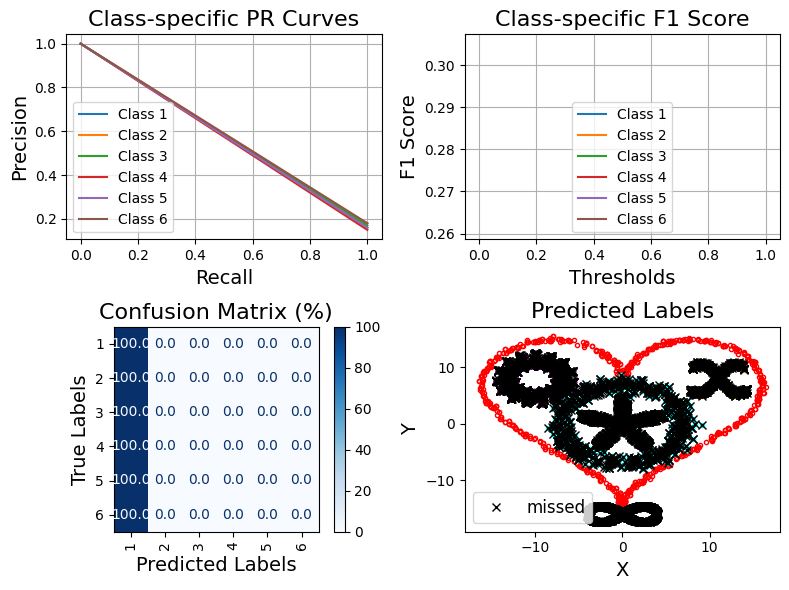

In [25]:
# Final evaluation of the model
evaluate_model(model,test_dataloader)

## References

[1] https://en.wikipedia.org/wiki/Linear_regression

[2] https://en.wikipedia.org/wiki/Classification

[3] https://docs.pytorch.org/docs/2.2/nn.html

[4] https://docs.pytorch.org/docs/2.2/nn.html#loss-functions

[5] https://docs.pytorch.org/docs/2.2/optim.html#module-torch.optim
